In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os

In [2]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [3]:
Pressure = [100, 75, 65, 55, 40, 30] # hPa
Height   = [16,  18, 19, 20, 22, 24] # km

Season = ["Winter", "Spring", "Summer", "Autumn"]

In [4]:
N_head = 5 # first 5 lines are head lines, not include data
N_column = 4

# Nx = 36
# Ny = 21
# Nz = 5
# N_parcel = 3780

Nx = 24
Ny = 21
Nz = 6
N_parcel = Nx*Ny*Nz

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    

directory = './Lifetime/'
filename = "Lifetime_"+Years[0]+Months[0]+Days[0]+".txt"
print(directory+filename)

./Lifetime/Lifetime_20000101.txt


In [5]:
N_year  = len(Years)
N_month = len(Months)
N_day   = len(Days)

lifetime   = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_N = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_S = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lon = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lat = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lev = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

lifetime.shape

(6, 21, 24, 10, 12, 10)

In [7]:
for i_year in range(N_year):
    for i_month in tqdm(range(N_month)):
        for i_day in range(N_day):
            directory = './../Lifetime/'
            filename = "Lifetime_"+Years[i_year]+Months[i_month]+Days[i_day]+".txt"
            File = open(directory+filename, 'r')
        
            Lines = File.readlines()

            # Strips the newline character
            data = []
            data_N = []
            data_S = []
            data_x = []
            data_y = []
            data_z = []
            for line in Lines:
                a = line.split(',')
                data.append(float(a[0])) # total lifetime
                data_N.append(float(a[1])) # total N lifetime
                data_S.append(float(a[2])) # total S lifetime
                data_x.append(float(a[3])) # lon
                data_y.append(float(a[4])) # lat
                data_z.append(float(a[5])) # p
    
            i = 0
            for ix in range(Nx):
                for iy in range(Ny):
                    for iz in range(Nz):
                        lifetime[iz,iy,ix,i_day,i_month,i_year] = data[i]
                        lifetime_N[iz,iy,ix,i_day,i_month,i_year] = data_N[i]
                        lifetime_S[iz,iy,ix,i_day,i_month,i_year] = data_S[i]
                        Lon[iz,iy,ix,i_day,i_month,i_year] = data_x[i]
                        Lat[iz,iy,ix,i_day,i_month,i_year] = data_y[i]
                        Lev[iz,iy,ix,i_day,i_month,i_year] = data_z[i]

                        i = i+1
                        
                        

100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


In [8]:
# season-mean
# lifetime(Nz, Ny, Nx, N_day, N_month, N_year)

lifetime_mon = np.mean(lifetime, axis=(3,5))
lifetime_N_mon = np.mean(lifetime_N, axis=(3,5))
lifetime_S_mon = np.mean(lifetime_S, axis=(3,5))


# lifetime_mon(Nz, Ny, Nx, N_month)
N_season = 4

lifetime_season = np.zeros((Nz, Ny, Nx, N_season))
lifetime_N_season = np.zeros((Nz, Ny, Nx, N_season))
lifetime_S_season = np.zeros((Nz, Ny, Nx, N_season))


# for Winter
lifetime_season[:,:,:,0]   = np.mean(lifetime_mon[:,:,:,[0,1,11]], axis=3)
lifetime_N_season[:,:,:,0] = np.mean(lifetime_N_mon[:,:,:,[0,1,11]], axis=3)
lifetime_S_season[:,:,:,0] = np.mean(lifetime_S_mon[:,:,:,[0,1,11]], axis=3)
    
# for Spring, Summer and Autumn
for i in range(1,N_season):
    print(i,i*3-1,(i+1)*3-1)
    lifetime_season[:,:,:,i]   = np.mean(  lifetime_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    lifetime_N_season[:,:,:,i] = np.mean(lifetime_N_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    lifetime_S_season[:,:,:,i] = np.mean(lifetime_S_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    
lifetime_season.shape

1 2 5
2 5 8
3 8 11


(6, 21, 24, 4)

In [9]:
# regrid (lon,lat) from (10,2) to (30,6)
# combin 3x3 to 1 grid

Nx3 = int(Nx/3)
Ny3 = int(Ny/3)

lifetime_season_9   = np.zeros((Nz, Ny3, Nx3, N_season))
lifetime_N_season_9 = np.zeros((Nz, Ny3, Nx3, N_season))
lifetime_S_season_9 = np.zeros((Nz, Ny3, Nx3, N_season))
D_lifetime_season_9 = np.zeros((Nz, Ny3, Nx3, N_season))

for ix in range(Nx3):
    for iy in range(Ny3):
        lifetime_season_9[:,iy,ix,:]   = np.mean(  lifetime_season[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        lifetime_N_season_9[:,iy,ix,:] = np.mean(lifetime_N_season[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        lifetime_S_season_9[:,iy,ix,:] = np.mean(lifetime_S_season[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        D_lifetime_season_9[:,iy,ix,:] = lifetime_N_season_9[:,iy,ix,:] - lifetime_S_season_9[:,iy,ix,:]
        
Lon2d_3 = Lon[0,1:Ny:3,1:Nx:3,0,0,0]
Lat2d_3 = Lat[0,1:Ny:3,1:Nx:3,0,0,0]
Lev2d_3 = Lev[0,1:Ny:3,1:Nx:3,0,0,0]

lifetime_season_9.shape, Lon2d_3.shape


((6, 7, 8, 4), (7, 8))

In [10]:
print(Ny*Nx*N_day*N_season*N_year)

201600


In [11]:
# first test: one time injection
#
# Lon2d = Lon[0,:,:,0,0,0]
# Lat2d = Lat[0,:,:,0,0,0]
# Lev2d = Lev[0,:,:,0,0,0]

# Lon1d = Lon2d
# Lat1d = Lat2d
# Lev1d = Lev2d


#


In [12]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html

# (Nz, Ny, Nx, N_season)
Result_season  = lifetime_season_9[0,:,:,:]*0.0
Lifetime_LP    = lifetime_season_9[:,:,:,:]*0.0
Lifetime_LP_N  = lifetime_season_9[:,:,:,:]*0.0
Lifetime_LP_S  = lifetime_season_9[:,:,:,:]*0.0
D_lifetime_LP  = lifetime_season_9[:,:,:,:]*0.0

iz = 1
Diff_NS = 0.01

# for LP solve: max lifetime under the interhemispheric balance
for iz in range(Nz):
    print(iz)
    for iseason in range(N_season):
        Life   = lifetime_season_9[iz,:,:,iseason].flatten()
        Life_S = lifetime_N_season_9[iz,:,:,iseason].flatten()
        Life_N = lifetime_S_season_9[iz,:,:,iseason].flatten()

        if sum(Life_S)+sum(Life_N)-sum(Life)>0.01: print("ERROR!!!")
    
        N = len(Life)

        #
        c = -1*Life

        Xs_bounds = []
        A1 = []
        A3 = []
        A4 = []
        A  = []
        for i in range(N):
            Xs_bounds.append((0, N))
            A1.append(1)
            A3.append( Life_N[i] -Life_S[i] -Diff_NS*Life[i] )
            A4.append( -1*(Life_N[i] -Life_S[i] +Diff_NS*Life[i]) )

        Aub = [A3,A4]
        Aeq = [A1]   

        b_ub = [0,0]
        b_eq = [N]

        from scipy.optimize import linprog
        res = linprog(c, A_eq=Aeq, b_eq=b_eq, A_ub=Aub, b_ub=b_ub, bounds=Xs_bounds)
    
        # post-process, calculate the injection percentage
        Result1d = np.round(res.x)
        Result2d = Result1d.reshape(Ny3,Nx3)
        Result2d = Result2d/np.sum(Result2d)*100
    
        Result_season[:,:,iseason] = Result2d
    
    Lifetime_LP[iz,:,:,:] = lifetime_season_9[iz,:,:,:]* (Result_season/100)

    Lifetime_LP_N[iz,:,:,:] = lifetime_N_season_9[iz,:,:,:]* (Result_season/100)
    Lifetime_LP_S[iz,:,:,:] = lifetime_S_season_9[iz,:,:,:]* (Result_season/100)
    D_lifetime_LP[iz,:,:,:] = Lifetime_LP_N[iz,:,:,:] - Lifetime_LP_S[iz,:,:,:]

print(lifetime_season_9[:,:,:,:].shape, Result_season.shape)


0
1
2
3
4
5
(6, 7, 8, 4) (7, 8, 4)


In [13]:
# get the max lifetime

Inject_percent = np.zeros((Nz, Ny3, Nx3, N_season))
Lifetime_max   = np.zeros((Nz, Ny3, Nx3, N_season))
Lifetime_max_N = np.zeros((Nz, Ny3, Nx3, N_season))
Lifetime_max_S = np.zeros((Nz, Ny3, Nx3, N_season))
D_lifetime_max = np.zeros((Nz, Ny3, Nx3, N_season))

print(Inject_percent.shape)

for iz in range(Nz):
    for i_season in range(N_season):
        a   = lifetime_season_9[iz,:,:,i_season]
        idx = np.unravel_index(np.argmax(a, axis=None), a.shape)
#         print(iz,idx[0],idx[1],i_season)
        Inject_percent[iz,idx[0],idx[1],i_season] = 100


    Lifetime_max[iz,:,:,:] = lifetime_season_9[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)

    Lifetime_max_N[iz,:,:,:] = lifetime_N_season_9[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)
    Lifetime_max_S[iz,:,:,:] = lifetime_S_season_9[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)
    D_lifetime_max[iz,:,:,:] = Lifetime_max_N[iz,:,:,:] - Lifetime_max_S[iz,:,:,:]
    
    


(6, 7, 8, 4)


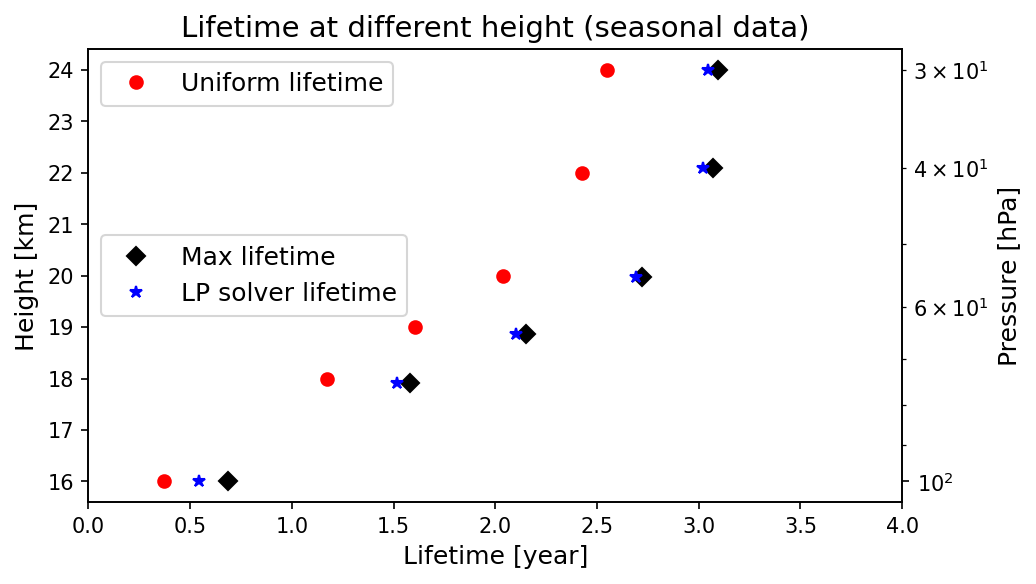

In [14]:
Life_LP_season = np.sum(Lifetime_LP[:,:,:,:], axis=(1,2))/365.25
Life_max_season = np.sum(Lifetime_max[:,:,:,:], axis=(1,2))/365.25
Life_uniform_season = np.mean(lifetime_season_9[:,:,:,:],axis=(1,2))/365.25

Life_LP_z  = np.mean(Life_LP_season[:,:],axis=1)
Life_max_z = np.mean(Life_max_season[:,:],axis=1)
Life_uniform_z = np.mean(Life_uniform_season[:,:],axis=1)

### plot
fig, ax1 = plt.subplots(figsize=(7,4), dpi=150)

###
ax1.plot(Life_uniform_z, Height, 'ro', label='Uniform lifetime')

ax1.set_xlim(0,4)

ax1.set_xlabel('Lifetime [year]', fontsize=12)
ax1.set_ylabel('Height [km]', fontsize=12)
ax1.legend(loc='upper left', fontsize=12);

###
ax2 = ax1.twinx()
ax2.plot(Life_max_z, Pressure, 'kD', label='Max lifetime')
ax2.plot(Life_LP_z, Pressure, 'b*', label='LP solver lifetime')

ax2.set_ylabel('Pressure [hPa]', fontsize=12)
ax2.set_yscale('log')
ax2.invert_yaxis()
ax2.legend(loc="center left", fontsize=12);

###
# ax3 = ax1.twinx()
# ax3.plot(Life_LP_z, Pressure, 'b*', label='LP solver lifetime')

# ax3.set_ylabel('Pressure [hPa]', fontsize=12)
# ax3.set_yscale('log')
# ax3.invert_yaxis()
# ax3.legend(loc="upper left", fontsize=12);


plt.title('Lifetime at different height (seasonal data)', fontsize=14);

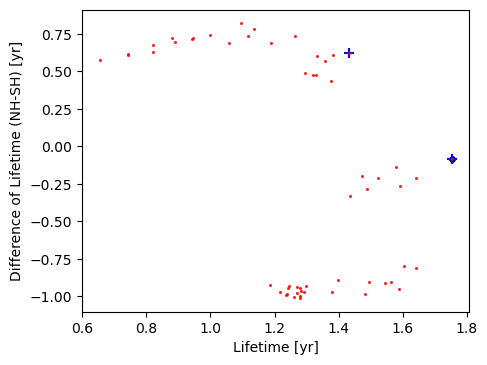

In [15]:
iseason = 2
iz = 1

# find the location
iy_max, ix_max = np.where(Lifetime_max[iz,:,:,iseason] == np.max(Lifetime_max[iz,:,:,iseason]))
iy_LP, ix_LP = np.where(Lifetime_LP[iz,:,:,iseason] > 0)

# plot
D_life = lifetime_N_season_9 - lifetime_S_season_9

figure = plt.figure(figsize=(5,4), dpi=100)

plt.scatter(lifetime_season_9[iz,iy_max,ix_max,iseason]/365, D_life[iz,iy_max,ix_max,iseason]/365, 
            marker='o', color='black', s=15, alpha=1)

plt.scatter(lifetime_season_9[iz,iy_LP,ix_LP,iseason]/365, D_life[iz,iy_LP,ix_LP,iseason]/365, 
            marker='+', color='blue', s=60, alpha=1)

plt.scatter(lifetime_season_9[iz,:,:,iseason]/365, D_life[iz,:,:,iseason]/365, \
            marker='.', color='red', s=6, alpha=0.8)

plt.xlabel("Lifetime [yr]")
plt.ylabel("Difference of Lifetime (NH-SH) [yr]");


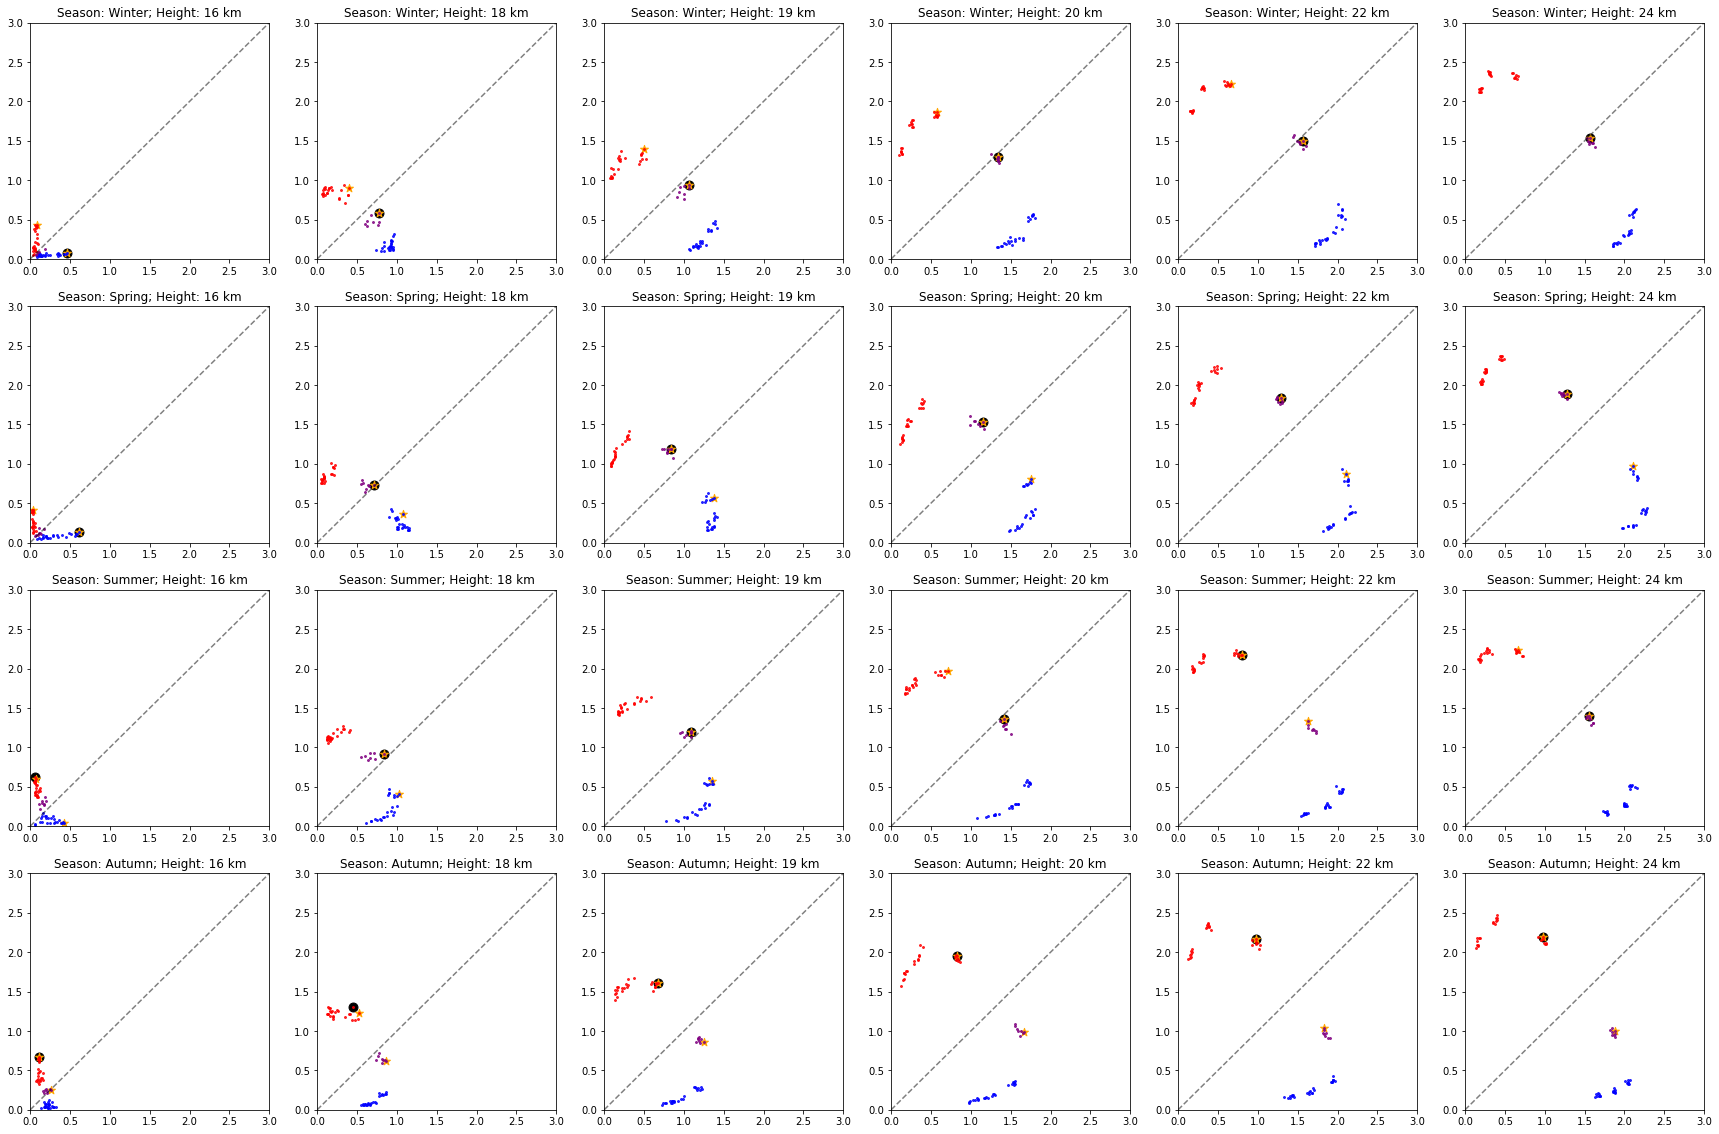

In [16]:
figure, axis = plt.subplots(len(Season), len(Height), figsize=(5*len(Height),5*len(Season)))

for iseason in range(len(Season)):
    for iz in range(len(Height)):

        # find the location
        iy_max, ix_max = np.where(Lifetime_max[iz,:,:,iseason] == np.max(Lifetime_max[iz,:,:,iseason]))
        iy_LP, ix_LP = np.where(Lifetime_LP[iz,:,:,iseason] > 0)

        # plot
        D_life = lifetime_N_season_9 - lifetime_S_season_9

#     figure = plt.figure(figsize=(6,6), dpi=100)

        axis[iseason, iz].scatter(lifetime_N_season_9[iz,iy_max,ix_max,iseason]/365, 
            lifetime_S_season_9[iz,iy_max,ix_max,iseason]/365, 
            marker='o', color='black', s=80, alpha=1, label='Max Injection')


        axis[iseason, iz].scatter(lifetime_N_season_9[iz,iy_LP,ix_LP,iseason]/365, 
            lifetime_S_season_9[iz,iy_LP,ix_LP,iseason]/365, 
            marker='*', color='orange', s=70, alpha=1, label='LP Injection')


        axis[iseason, iz].scatter(lifetime_N_season_9[iz,0:3,:,iseason]/365, 
            lifetime_S_season_9[iz,0:3,:,iseason]/365, 
            marker='.', color='red', s=15, alpha=0.8, label='Injection in SH')

        axis[iseason, iz].scatter(lifetime_N_season_9[iz,3,:,iseason]/365, 
            lifetime_S_season_9[iz,3,:,iseason]/365, 
            marker='.', color='purple', s=15, alpha=0.8, label='Injection in Equator')

        axis[iseason, iz].scatter(lifetime_N_season_9[iz,4:7,:,iseason]/365, 
            lifetime_S_season_9[iz,4:7,:,iseason]/365, 
            marker='.', color='blue', s=15, alpha=0.8, label='Injection in NH')

        axis[iseason, iz].plot([0,3], [0,3], 'k--', alpha=0.5)

        axis[iseason, iz].set_xlim(0,3)
        axis[iseason, iz].set_ylim(0,3)

#         axis[iseason, iz].set_xlabel("lifetime_N_season [yr]")
#         axis[iseason, iz].set_ylabel("lifetime_S_season [yr]");
        axis[iseason, iz].set_title(f"Season: {Season[iseason]}; Height: {Height[iz]:.0f} km")

#         axis[iseason, iz].legend()

        lifetime_N_season_9.shape

In [ ]:
# D_Life_LP_season = np.sum(D_lifetime_LP[:,:,:,:], axis=(1,2))/365.25
# D_Life_max_season = np.sum(D_lifetime_max[:,:,:,:], axis=(1,2))/365.25
# D_Life_uniform_season = np.mean(D_lifetime_season_9[:,:,:,:],axis=(1,2))/365.25


# D_Life_LP_z  = np.mean(D_Life_LP_season[:,:],axis=1)
# D_Life_max_z = np.mean(D_Life_max_season[:,:],axis=1)
# D_Life_uniform_z = np.mean(D_Life_uniform_season[:,:],axis=1)

# ### plot
# fig, ax1 = plt.subplots(figsize=(7,4), dpi=150)

# ###
# ax1.plot(D_Life_uniform_z, Height, 'ro', label='Uniform lifetime')

# # ax1.set_xlim(0,4)

# ax1.set_xlabel('Lifetime [year]', fontsize=12)
# ax1.set_ylabel('Height [km]', fontsize=12)
# ax1.legend(loc='upper left', fontsize=12);

# ###
# ax2 = ax1.twinx()
# ax2.plot(D_Life_max_z, Pressure, 'kD', label='Max lifetime')
# ax2.plot(D_Life_LP_z, Pressure, 'b*', label='LP solver lifetime')

# ax2.set_ylabel('Pressure [hPa]', fontsize=12)
# ax2.set_yscale('log')
# ax2.invert_yaxis()
# ax2.legend(loc="lower left", fontsize=12);

# ###
# # ax3 = ax1.twinx()
# # ax3.plot(D_Life_LP_z, Pressure, 'b*', label='LP solver lifetime')

# # ax3.set_ylabel('Pressure [hPa]', fontsize=12)
# # ax3.set_yscale('log')
# # ax3.invert_yaxis()
# # ax3.legend(loc="upper left", fontsize=12);


# plt.title('Diff_Lifetime at different height (seasonal data)', fontsize=14);

In [ ]:
# find the (ix, iy) for the LP injection and Max injection

# iy_max, ix_max = np.where(Lifetime_max[:,:,imon] == np.max(Lifetime_max[:,:,imon]))
# print(iy_max[0], ix_max[0])

# Lifetime_max[iy_max,ix_max,imon], lifetime_mon_9[iz,iy_max,ix_max,imon]

In [ ]:
# iy_LP, ix_LP = np.where(Lifetime_LP[:,:,imon] > 0)
# print(iy_LP, ix_LP)

# Lifetime_LP2[iy_LP,ix_LP,imon], lifetime_mon_9[iz,iy_LP,ix_LP,imon]

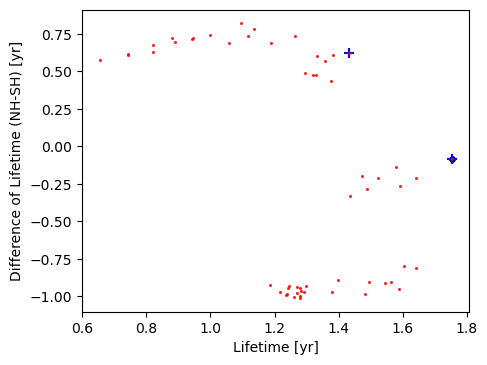

In [20]:
iseason = 2
iz = 1

# find the location
iy_max, ix_max = np.where(Lifetime_max[iz,:,:,iseason] == np.max(Lifetime_max[iz,:,:,iseason]))
iy_LP, ix_LP = np.where(Lifetime_LP[iz,:,:,iseason] > 0)

# plot
D_life = lifetime_N_season_9 - lifetime_S_season_9

figure = plt.figure(figsize=(5,4), dpi=100)

plt.scatter(lifetime_season_9[iz,iy_max,ix_max,iseason]/365, D_life[iz,iy_max,ix_max,iseason]/365, 
            marker='o', color='black', s=15, alpha=1)
plt.scatter(lifetime_season_9[iz,iy_LP,ix_LP,iseason]/365, D_life[iz,iy_LP,ix_LP,iseason]/365, 
            marker='+', color='blue', s=60, alpha=1)

plt.scatter(lifetime_season_9[iz,:,:,iseason]/365, D_life[iz,:,:,iseason]/365, 
            marker='.', color='red', s=6, alpha=0.8)

plt.xlabel("Lifetime [yr]")
plt.ylabel("Difference of Lifetime (NH-SH) [yr]");

In [22]:
iseason = 2

# find the location
iy_max, ix_max = np.where(Lifetime_max[:,:,iseason] == np.max(Lifetime_max[:,:,iseason]))
iy_LP, ix_LP = np.where(Lifetime_LP[:,:,iseason] > 0)

# plot
D_life = lifetime_N_season_9 - lifetime_S_season_9

figure = plt.figure(figsize=(5,4), dpi=100)

plt.scatter(lifetime_season_9[iz,iy_max,ix_max,iseason]/365, D_life[iz,iy_max,ix_max,iseason]/365, marker='o', color='black', s=15, alpha=1)
plt.scatter(lifetime_season_9[iz,iy_LP,ix_LP,iseason]/365, D_life[iz,iy_LP,ix_LP,iseason]/365, marker='+', color='blue', s=60, alpha=1)

plt.scatter(lifetime_season_9[iz,:,:,iseason]/365, D_life[iz,:,:,iseason]/365, marker='.', color='red', s=6, alpha=0.8)

plt.xlabel("Lifetime [yr]")
plt.ylabel("Difference of Lifetime (NH-SH) [yr]");


ValueError: too many values to unpack (expected 2)

In [26]:
from copy import copy

palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent

NameError: name 'i_mon' is not defined

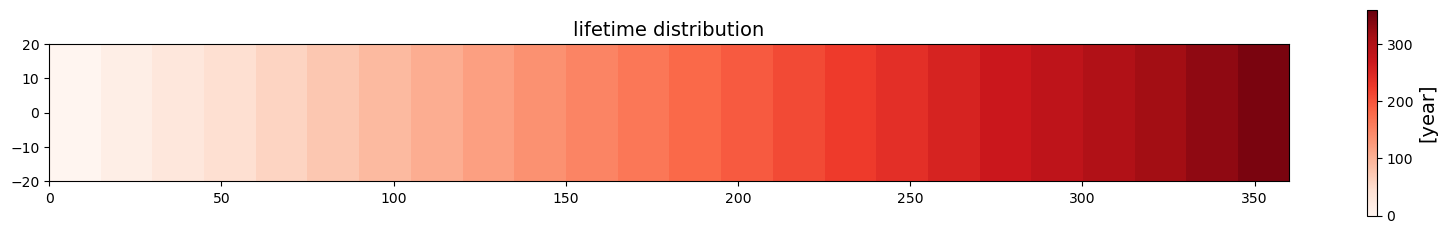

In [23]:
# check lon, lat are correct!!!

fig = plt.figure(figsize=(20,6), dpi=100)
extent = [0 , 360 , -20 , 20]

# Lon[iz,iy,ix,i_day,i_month,i_year]
# lifetime
ax0 = plt.subplot(2, 1, 1)

ax0_pixel = plt.imshow(Lon[0,:,:,0,0,0], vmin=0, vmax=360,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb0 = plt.colorbar(ax0_pixel, ax=ax0)
cb0.set_label('[year]', fontsize=14);

ax0.set_title(f"lifetime distribution", fontsize=14);
ax0.set_title(f"Month: {i_mon+1}", fontsize=14, loc="left");


###
ax1 = plt.subplot(2, 1, 2)

ax1_pixel = plt.imshow(Lat[0,:,:,0,0,0], vmin=-20, vmax=20,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[year]', fontsize=14);

ax1.set_title(f"lifetime distribution", fontsize=14);
ax1.set_title(f"Month: {i_mon+1}", fontsize=14, loc="left");

## Important for ploting: lat should be reversed!!!



NameError: name 'lifetime_mon_9' is not defined

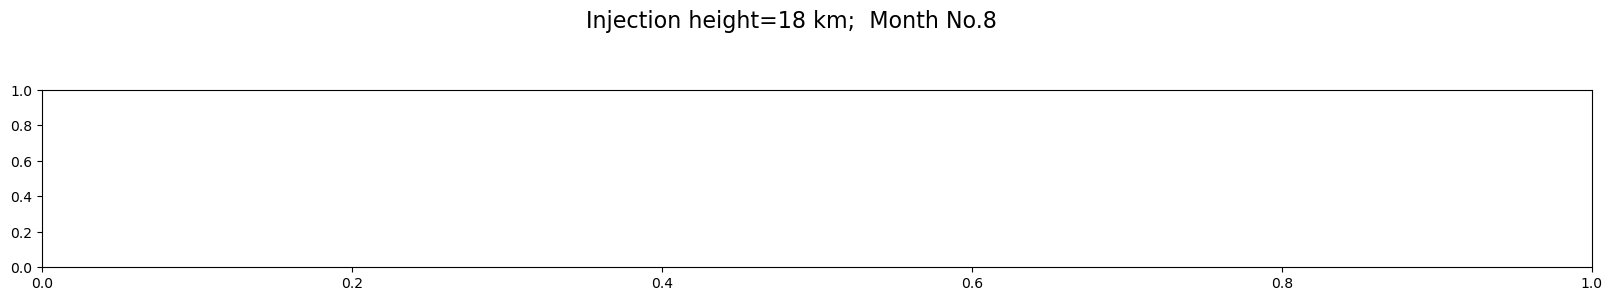

In [24]:
# select one month as a example

i_mon = 7

Life_LP = np.sum(Lifetime_LP[:,:,i_mon]/365.25, axis=(0,1))
Life_max = np.sum(Lifetime_max[:,:,i_mon]/365.25, axis=(0,1))


D_Life_LP = np.sum(D_lifetime_LP[:,:,i_mon]/365.25, axis=(0,1))
D_Life_max = np.sum(D_lifetime_max[:,:,i_mon]/365.25, axis=(0,1))


fig = plt.figure(figsize=(20,8), dpi=100)
plt.suptitle(f"Injection height={Height[iz]:.0f} km;  Month No.{i_mon+1}", fontsize=16);

extent = [0 , 360 , -20 , 20]

# Lon[iz,iy,ix,i_day,i_month,i_year]

#-----------------------------------------------------
# (1) lifetime
#-----------------------------------------------------
ax0 = plt.subplot(3, 1, 1)

ax0_pixel = plt.imshow(lifetime_mon_9[iz,::-1,:,i_mon]/365, vmin=1.3, vmax=2.5,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb0 = plt.colorbar(ax0_pixel, ax=ax0)
cb0.set_label('[year]', fontsize=14);

Life_uniform = np.mean(lifetime_mon_9[iz,::-1,:,i_mon],axis=(0,1))/365

ax0.set_title(f"lifetime distribution", fontsize=14);
ax0.set_title(f"lifetime:{Life_uniform:.2f} yr", 
              fontsize=14, loc="right");

D_Life_uniform = np.mean(lifetime_N_mon_9[iz,:,:,i_mon]-lifetime_S_mon_9[iz,:,:,i_mon], axis=(0,1))/365

ax0.set_title(f"lifetime diff (NH-SH): {D_life_uniform:.2f} yr ({100*D_Life_uniform/Life_uniform:.0f}%)", 
              fontsize=14, loc="left");

#----------------------------------------------------
# (2) maximum lifetime
#-----------------------------------------------------
ax1 = plt.subplot(3, 1, 2)
ax1_pixel = plt.imshow(Inject_percent[iz,::-1,:,i_mon], vmin=0, vmax=100,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('Injection percentage [%]', fontsize=14);

ax1.set_title(f"maximum lifetime", fontsize=14);
ax1.set_title(f"lifetime:{Life_max:.2f} yr", fontsize=14, loc="right");
ax1.set_title(f"lifetime diff (NH-SH): {D_Life_max:.2f} yr ({100*D_Life_max/Life_max:.0f}%)", 
              fontsize=14, loc="left");


#-----------------------------------------------------
# (3) maximum lifetime and ensrue interhemispheric balance
#-----------------------------------------------------
ax2 = plt.subplot(3, 1, 3)
ax2_pixel = plt.imshow(Result_mon[::-1,:,i_mon], vmin=0, vmax=100,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb2 = plt.colorbar(ax2_pixel, ax=ax2)
cb2.set_label('[%]', fontsize=14);

ax2.set_title("maximum lifetime + interhemispheric balance (LP solver)", fontsize=14);
ax2.set_title(f"lifetime:{Life_LP:.2f} yr", fontsize=14, loc="right");
ax2.set_title(f"lifetime diff (NH-SH): {D_Life_LP:.2f} yr ({100*D_Life_LP/Life_LP:.0f}%)", 
              fontsize=14, loc="left");

plt.tight_layout()